In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, Bidirectional, LSTM, Flatten, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import backend as K

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import RobertaTokenizer, RobertaForSequenceClassification

import torch
from torch.utils.data import DataLoader, RandomSampler, TensorDataset, SequentialSampler

import seaborn as sns

from tqdm import tqdm

2024-03-27 12:04:05.685421: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-27 12:04:05.685486: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-27 12:04:05.687095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-27 12:04:05.695192: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train = pd.read_csv('emotions_all.csv') # My dataset

train.head() # Display the first 5 rows of the train dataset

,sentence,emotion
0,That game hurt.,sadness
1,Man I love reddit.,happiness
2,Right? Considering it’s such an important docu...,happiness
3,"He isn't as big, but he's still quite popular....",disgust
4,That's crazy; I went to a super [RELIGION] hig...,happiness


In [3]:
# Find the unique emotions
unique_emotions = train['emotion'].unique()

# Initialize an empty DataFrame to hold the filtered dataset
filtered_train = pd.DataFrame()

for emotion in unique_emotions:
    # Filter the dataset for the current emotion
    emotion_df = train[train['emotion'] == emotion]
    
    # Check if the emotion_df has more than 3000 rows
    if len(emotion_df) > 1000:
        # If so, take the first 3000
        emotion_df = emotion_df.head(1000)
    
    # Concatenate the filtered emotion_df to the filtered_df
    filtered_train = pd.concat([filtered_train, emotion_df])

# Reset index of the filtered DataFrame
filtered_train = filtered_train.reset_index(drop=True)

filtered_train

,sentence,emotion
0,That game hurt.,sadness
1,"I wanted to downvote this, but it's not your f...",sadness
2,That is odd.,sadness
3,So happy for [NAME]. So sad he's not here. Ima...,sadness
4,"Dark and funny, but not really nice guy. He ha...",sadness
...,...,...
5995,My chest tightened so quickly,fear
5996,"Seriously, way to miss the point. Even if no l...",fear
5997,no one cares my guy,fear
5998,Wow that’s weird. I’m too used to that age gro...,fear


In [4]:
filtered_train['emotion'].value_counts()

emotion
sadness      1000
happiness    1000
disgust      1000
surprise     1000
anger        1000
fear         1000
Name: count, dtype: int64

In [5]:
test = pd.read_csv('test.csv', sep='\t')

test.head() #Display the first 5 rows of the test dataset

,id,sentence
0,0,Girls are happy when they get flowers
1,1,His jaw dropped in disbelief when he saw the p...
2,2,Sometimes the ugly stench makes me wanna throw...
3,3,The foul odor from the garbage bin was disgust...
4,4,"I can’t believe it, they lost the game in the ..."


In [6]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(filtered_train['sentence'], filtered_train['emotion'], test_size=0.2, random_state=42)

In [7]:
# Create a global label dictionary
global_label_dict = {label: idx for idx, label in enumerate(unique_emotions)}

def encode_data(tokenizer, sentences, labels, label_dict, max_length=64):
    input_ids = []
    attention_masks = []
    numeric_labels = [label_dict[label] for label in labels]
    
    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(numeric_labels)

    return input_ids, attention_masks, labels

In [8]:
# Load the RoBERTa tokenizer.
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Encode the data using the global label dictionary
train_inputs, train_masks, train_labels = encode_data(tokenizer, X_train.tolist(), y_train.tolist(), global_label_dict)
val_inputs, val_masks, val_labels = encode_data(tokenizer, X_val.tolist(), y_val.tolist(), global_label_dict)

In [9]:
# Create DataLoader for training
batch_size = 64
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)

# Create DataLoader for validation
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
validation_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

In [10]:
num_labels = len(global_label_dict)  # Number of unique labels

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=num_labels  # The number of output labels
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move the model to the GPU if available

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [12]:
# Define the number of epochs
epochs = 20

optimizer = AdamW(model.parameters(),
                  lr=5e-5  # Learning rate
                 )

# Calculate the total number of training steps
total_steps = len(train_dataloader) * epochs

# Define warmup steps as a percentage of total steps
warmup_ratio = 0.1  # Use 10% of the total steps for warmup
warmup_steps = int(total_steps * warmup_ratio)

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,  # Default value in transformers
                                            num_training_steps=total_steps)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [14]:
# Function to calculate the accuracy of predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training loop
for epoch_i in range(epochs):
    print(f"{'='*8} Epoch {epoch_i+1} / {epochs} {'='*8}")

    # Training
    model.train()
    total_loss = 0

    for step, batch in tqdm(enumerate(train_dataloader), desc="Training", total=len(train_dataloader)):
        # Move batch to the appropriate device
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)

        model.zero_grad()

        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()

        # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()  # Adjust the learning rate based on the schedule after each optimizer step

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss:.2f}")

    # Validation
    model.eval()
    total_eval_loss = 0
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in tqdm(validation_dataloader, desc="Validation", total=len(validation_dataloader)):
        # Move batch to the appropriate device
        b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
        
        # Turn off gradients to speed up this part
        with torch.no_grad():
            # Forward pass, get logit predictions
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels)
        
        # Extract the loss from the model's output
        loss = outputs.loss
        total_eval_loss += loss.item()  # Accumulate the validation loss
        
        # Move logits to CPU for evaluation purposes
        logits = outputs.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate accuracy for this batch and accumulate it over all batches
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy

        nb_eval_steps += 1
    
    # Calculate the average validation loss and accuracy over all batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    print(f"Validation Accuracy: {eval_accuracy / nb_eval_steps:.2f}")
    print(f"Validation loss: {avg_val_loss:.2f}")

print("Training complete")

======== Epoch 1 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.41it/s]


Average training loss: 1.63


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


Validation Accuracy: 0.46
Validation loss: 1.40
======== Epoch 2 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.49it/s]


Average training loss: 1.31


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.99it/s]


Validation Accuracy: 0.47
Validation loss: 1.40
======== Epoch 3 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.50it/s]


Average training loss: 1.14


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.84it/s]


Validation Accuracy: 0.46
Validation loss: 1.48
======== Epoch 4 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.49it/s]


Average training loss: 0.94


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Validation Accuracy: 0.44
Validation loss: 1.65
======== Epoch 5 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


Average training loss: 0.78


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.75it/s]


Validation Accuracy: 0.43
Validation loss: 1.72
======== Epoch 6 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


Average training loss: 0.64


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.95it/s]


Validation Accuracy: 0.41
Validation loss: 1.92
======== Epoch 7 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


Average training loss: 0.53


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.60it/s]


Validation Accuracy: 0.40
Validation loss: 2.18
======== Epoch 8 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.47it/s]


Average training loss: 0.46


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.93it/s]


Validation Accuracy: 0.39
Validation loss: 2.26
======== Epoch 9 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


Average training loss: 0.41


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.67it/s]


Validation Accuracy: 0.39
Validation loss: 2.37
======== Epoch 10 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.46it/s]


Average training loss: 0.38


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.80it/s]


Validation Accuracy: 0.40
Validation loss: 2.49
======== Epoch 11 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


Average training loss: 0.34


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


Validation Accuracy: 0.39
Validation loss: 2.55
======== Epoch 12 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


Average training loss: 0.30


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.53it/s]


Validation Accuracy: 0.39
Validation loss: 2.62
======== Epoch 13 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.45it/s]


Average training loss: 0.29


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.71it/s]


Validation Accuracy: 0.39
Validation loss: 2.68
======== Epoch 14 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.48it/s]


Average training loss: 0.28


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


Validation Accuracy: 0.38
Validation loss: 2.75
======== Epoch 15 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.49it/s]


Average training loss: 0.25


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.91it/s]


Validation Accuracy: 0.39
Validation loss: 2.86
======== Epoch 16 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.51it/s]


Average training loss: 0.24


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.79it/s]


Validation Accuracy: 0.38
Validation loss: 2.85
======== Epoch 17 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.51it/s]


Average training loss: 0.22


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.89it/s]


Validation Accuracy: 0.39
Validation loss: 2.95
======== Epoch 18 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.52it/s]


Average training loss: 0.21


Validation: 100%|██████████| 19/19 [00:01<00:00, 10.71it/s]


Validation Accuracy: 0.39
Validation loss: 3.01
======== Epoch 19 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.50it/s]


Average training loss: 0.19


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.08it/s]


Validation Accuracy: 0.39
Validation loss: 3.04
======== Epoch 20 / 20 ========


Training: 100%|██████████| 75/75 [00:21<00:00,  3.51it/s]


Average training loss: 0.18


Validation: 100%|██████████| 19/19 [00:01<00:00, 11.21it/s]

Validation Accuracy: 0.39
Validation loss: 3.05
Training complete


In [15]:
# Containers for predictions and labels
all_preds = []
all_true_labels = []

model.eval()
for batch in tqdm(validation_dataloader, desc="Evaluating"):
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
    
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # Store predictions and true labels
    all_preds.extend(np.argmax(logits, axis=1).flatten())
    all_true_labels.extend(label_ids.flatten())

# Ensure all_preds and all_true_labels are numpy arrays for confusion matrix computation
all_preds = np.array(all_preds)
all_true_labels = np.array(all_true_labels)

Evaluating: 100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


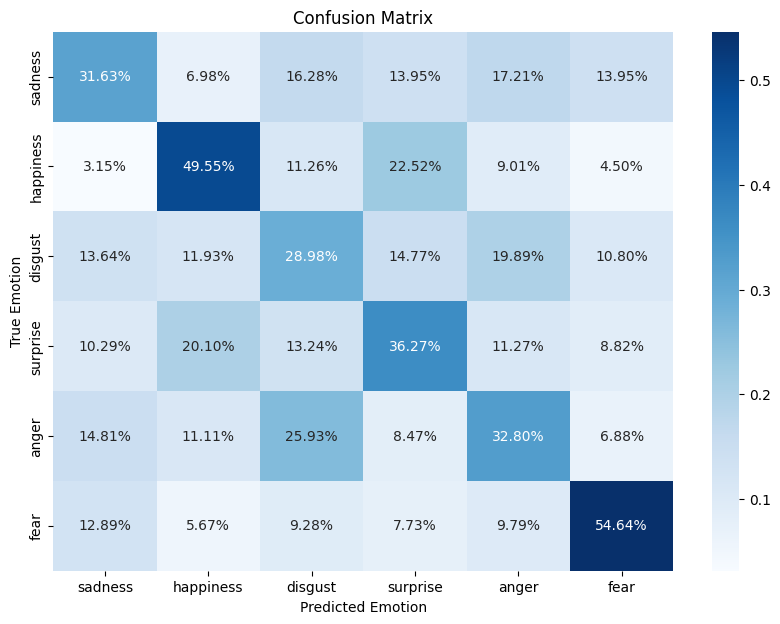

In [17]:
cm = confusion_matrix(all_true_labels, all_preds)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues", xticklabels=unique_emotions, yticklabels=unique_emotions)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Emotion")
plt.ylabel("True Emotion")
plt.show()

In [ ]:
test_sentences = test['sentence'].tolist()
test_ids = test['id'].tolist()

In [ ]:
def encode_test_data(tokenizer, sentences, max_length=64):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_length,  # Pad & truncate all sentences
            padding='max_length',  # Explicitly pad to the max length
            truncation=True,  # Explicitly truncate to the max length
            return_attention_mask=True,  # Construct attention masks
            return_tensors='pt',  # Return PyTorch tensors
        )
        
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    
    # Convert the lists into tensors
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

In [17]:
test_inputs, test_masks = encode_test_data(tokenizer, test_sentences)

In [18]:
# Create a TensorDataset for the test data
test_dataset = TensorDataset(test_inputs, test_masks)

# Create a DataLoader for the test set
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=64)  # Adjust batch size if necessary

In [19]:
model.eval()  # Set the model to evaluation mode

predictions = []

for batch in test_dataloader:
    # Move the inputs to the GPU
    b_input_ids, b_input_mask = tuple(t.to(device) for t in batch)
    
    with torch.no_grad():  # Temporarily set all the requires_grad flag to false
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits to CPU and convert to numpy array
    logits = outputs.logits.detach().cpu().numpy()
    predictions.extend(np.argmax(logits, axis=1))

In [20]:
# Assuming 'global_label_dict' is your emotion to index dictionary used for encoding the labels
inverse_label_dict = {v: k for k, v in global_label_dict.items()}
predicted_emotions = [inverse_label_dict[pred] for pred in predictions]

In [21]:
results_df = pd.DataFrame({
    'id': test_ids,
    'emotion': predicted_emotions
})

In [22]:
results_df

,id,emotion
0,0,happiness
1,1,surprise
2,2,disgust
3,3,disgust
4,4,sadness
...,...,...
1431,1431,sadness
1432,1432,surprise
1433,1433,happiness
1434,1434,fear


In [23]:
# Save to CSV
results_df.to_csv('bert_model_torch.csv', index=False)